#Actividad 6 Módulo 5

Ejercicio planteado

El problema que abordaremos es predecir la temperatura máxima para
mañana en una determinada ciudad usando un año de datos meteorológicos anteriores. Usted usará Seattle, WA, pero también puede buscar datos para otra ciudad usando la herramienta de datos climáticos en línea de la NOAA.
Tenemos acceso a un año de temperaturas máximas históricas, las
temperaturas de los dos días anteriores y una estimación de un amigo que siempre afirma saberlo todo sobre el clima. Este es un problema de aprendizaje automático de regresión supervisado. Durante el entrenamiento, para usar random forest debemos darle tanto las características como los objetivos, y debe aprender a asignar los datos a una predicción.
Para esto usará los datos meteorológicos para Seattle, WA de 2016 utilizando la herramienta de datos climáticos en línea de la NOAA. En general, alrededor del 80 % del tiempo dedicado al análisis de datos se dedica a la limpieza y recuperación de datos, pero esta carga de trabajo se puede reducir encontrando fuentes de datos de alta calidad. La herramienta NOAA es sorprendentemente fácil de usar y los datos de temperatura se pueden descargar como archivos csv limpios que se pueden analizar. 

El archivo de trabajo se llama temps.csv que encontrará cargado en la plataforma.

In [131]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn import tree
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [132]:
# escalado de todas las variables para trabajar con el modelo 
def escalar(df):
  # se utiliza estandarizador para eliminar valores atípicos (outlier) y que utiliza la dispersión gaussiana
  escalador = RobustScaler().fit_transform(df.values)
  # se escala para mantener valores positivos
  escalador = MinMaxScaler().fit_transform(pd.DataFrame(escalador, columns=df.columns.values))
  return pd.DataFrame(escalador, columns=df.columns.values)

In [133]:
# Load the Iris dataset
temps_df = pd.read_csv('./temps.csv')

Usted posee las siguientes variables para trabajar:

- year: 2016 para todos los puntos de datos
- month: número del mes del año
- day: número para el día del año
- week: día de la semana como cadena de caracteres
- temp_2: temperatura máxima 2 días antes
- temp_1: temperatura máxima 1 día antes
- average: temperatura máxima promedio histórica
- actual: medición de temperatura máxima
- friend: la predicción de tu amigo, un número aleatorio entre 20 por debajo del promedio y 20 por encima del promedio

Realice lo siguiente:
#1. 
Para identificar anomalías, obtenga un resumen estadístico, o dicho de otro modo, realice un análisis descriptivo de sus datos, comente.

In [134]:
temps_df.describe()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


In [135]:
temps_df.dtypes

year                int64
month               int64
day                 int64
week               object
temp_2              int64
temp_1              int64
average           float64
actual              int64
forecast_noaa       int64
forecast_acc        int64
forecast_under      int64
friend              int64
dtype: object

#Se observó:

- El dataframe contine una columna de tipo objeto que deberá ser codificada a numérica empleando alguna técnica para su conversión.

- Existen columnas numéricas con la finalidad de almacenar la fecha del registro pero esta fecha se encuentra segregada en 3 campos que almacenan el año, el meses y el dia respectivamente, es por esto que en base a esta información, se decide crear serie de tiempo y emplearlo como índice del dataframe.

- No hay registros de temperatura en un total de 18 días durante el año 2016.

- El dataframe contien un registro de 2 temperaturas atípicas (outlier), porque son demasiadas altas (117 °F), el día 31/10/2016 en temp_1 y el día 01/11/2016 en temp_2.






{'whiskers': [<matplotlib.lines.Line2D at 0x7f99780668c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9978064850>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9978066e30>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9978067640>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9978065f30>],
 'means': []}

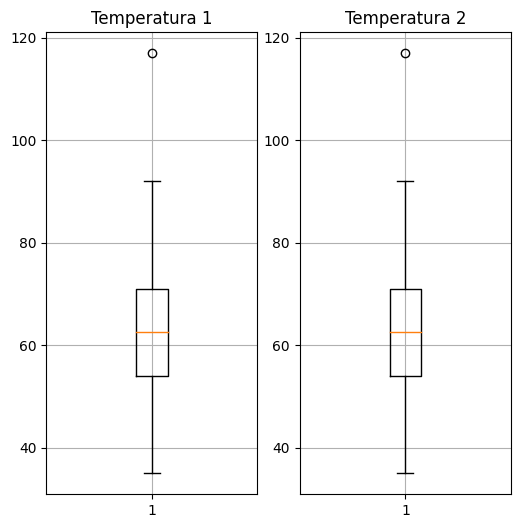

In [136]:
# revision de la valores atípicos
fig = plt.figure(figsize=(6,6))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.set_title("Temperatura 1")
ax1.grid(True)
ax1.boxplot(temps_df.temp_1)

ax2.set_title("Temperatura 2")
ax2.grid(True)
ax2.boxplot(temps_df.temp_2)

#2. 
Realice un análisis gráfico de las temperaturas máximas históricas, las temperaturas de los dos días anteriores y la estimación del amigo, con respecto a la fecha. Comente si hay anomalías.

In [137]:
temps_df.dtypes

year                int64
month               int64
day                 int64
week               object
temp_2              int64
temp_1              int64
average           float64
actual              int64
forecast_noaa       int64
forecast_acc        int64
forecast_under      int64
friend              int64
dtype: object

In [138]:
print(f'Número de filas con missing values: {temps_df.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [139]:
# creación de dataframe para utilizarlo como serie de tiempo en base a las columnas yer, month y day.
date_=[]
for i in range(len(temps_df)):
  date_.append(str(temps_df.year.iloc[i])+"-"+str(temps_df.month.iloc[i])+"-"+str(temps_df.day.iloc[i]))

# date_=[datetime.strptime(date, "%Y-%m-%d").date() for date in date_]

# modificación del dataframe para incluir serie de tiempo
temps_df['fecha'] = pd.to_datetime(date_, format='%Y/%m/%d')
temps_df = temps_df.set_index('fecha')
temps_df = temps_df.drop(['year','month','day'],axis=1)

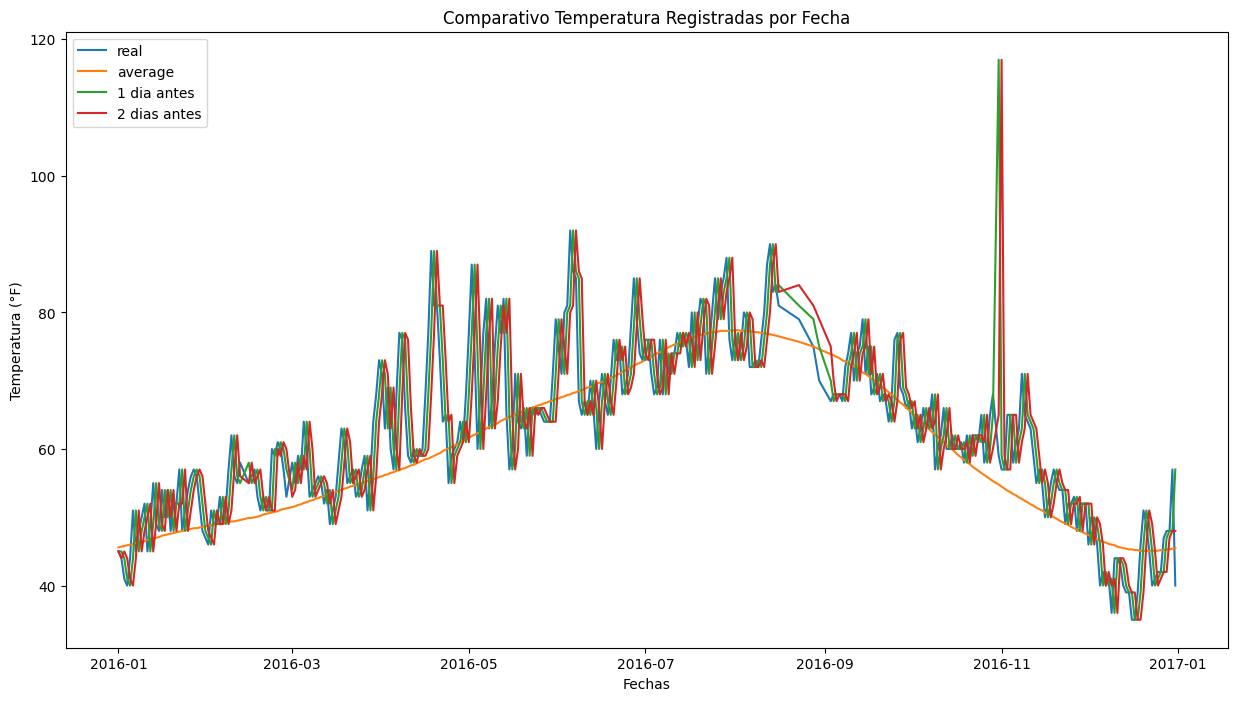

In [140]:
# grafico comparativo de temperaturas según dechas, entre el promedio, temperaturas 1 y 2 días y la real
fig = plt.figure(figsize=(15, 8))
plt.plot(temps_df.index, temps_df.actual, label = "real")
plt.plot(temps_df.index, temps_df.average, label="average")
plt.plot(temps_df.index, temps_df.temp_1, label = "1 dia antes")
plt.plot(temps_df.index, temps_df.temp_2, label = "2 dias antes")
plt.xlabel("Fechas")
plt.ylabel("Temperatura (°F)")
plt.legend(loc="upper left")
plt.title("Comparativo Temperatura Registradas por Fecha")
plt.show()

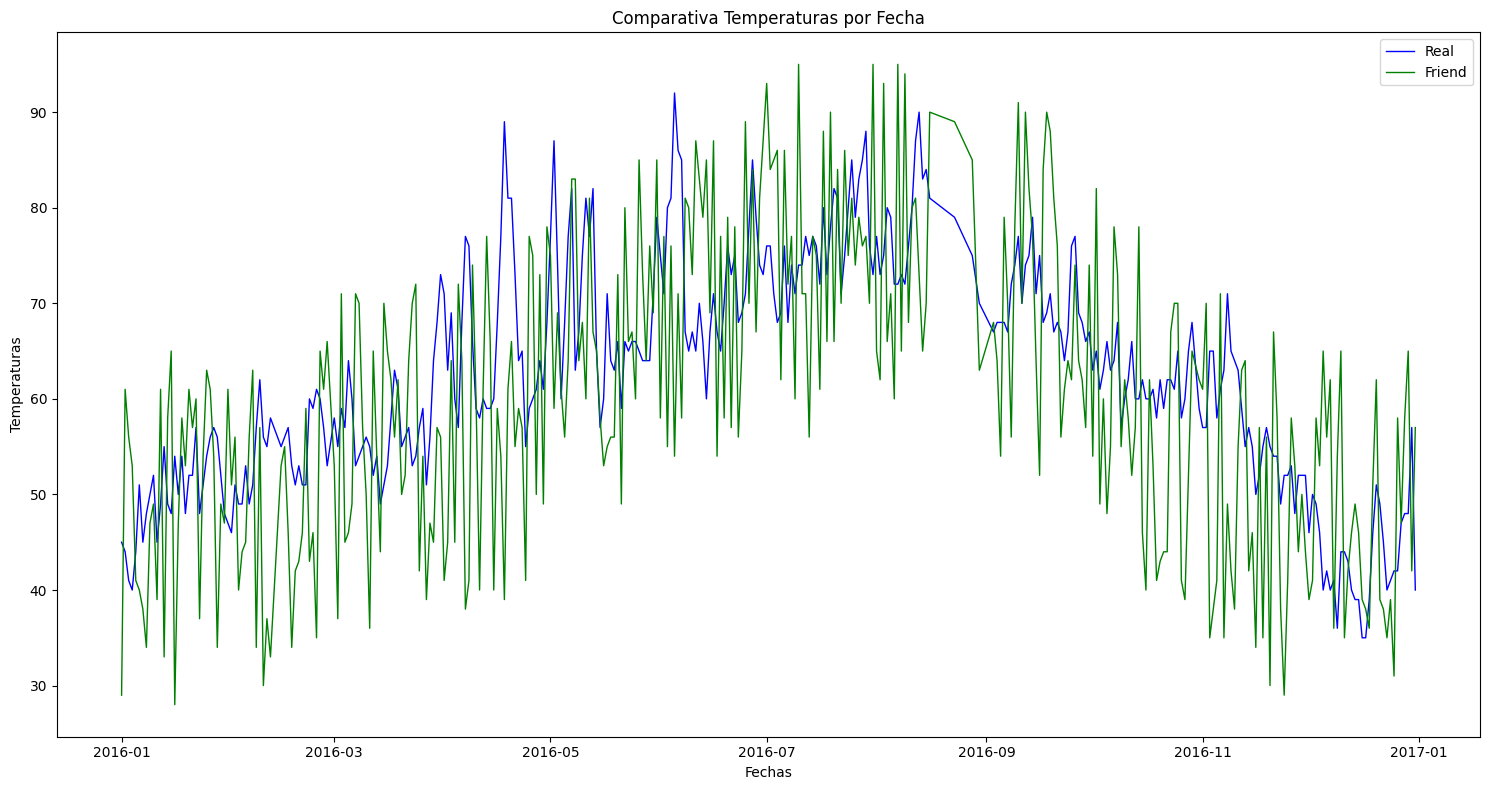

In [141]:
# grafico comparativo de temperaturas según dechas, entre el friend y la real
# Create figure
fig = plt.figure(figsize=(15, 8))
# Plot time series
plt.plot(temps_df.index, temps_df.actual, color="blue",
         label="Real", linewidth=1)
plt.plot(temps_df.index, temps_df.friend, color="green", 
         label="Friend", linewidth=1)
# Add title and labels
plt.tick_params(axis="x",labelsize=10)
plt.title('Comparativa Temperaturas por Fecha')
plt.xlabel('Fechas')
plt.ylabel('Temperaturas')
# Add legend
plt.legend()
# Auto space
plt.tight_layout()
# Display plot
plt.show() 

Preparación de la data:
#3. 
Recodifique los días de la semana, creando siete variables 1-0 asociados a los días de la semana. Le puede facilitar el proceso usando get_dummies de la librería Pandas.

In [142]:
# Creamos las variables binarias
week_dummies = pd.get_dummies(temps_df['week'])
# Añadimos las variables binarias al DataFrame
temps_df = pd.concat([temps_df, week_dummies], axis = 1)
temps_df.drop('week', axis=1, inplace=True)
temps_df.head(2)

,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,Fri,Mon,Sat,Sun,Thurs,Tues,Wed
fecha,,,,,,,,,,,,,,,
2016-01-01,45,45,45.6,45,43,50,44,29,1,0,0,0,0,0,0
2016-01-02,44,45,45.7,44,41,50,44,61,0,0,1,0,0,0,0


#4. 
Ahora, separe los datos en predictores y variable respuesta. Su variable Y es la temperatura máxima real y los predictores son todas las columnas que usa el modelo para hacer una predicción. Asegúrese de transformar en una matriz Numpy porque esa es la forma en que funciona el algoritmo.

In [143]:
X = temps_df.drop('actual', axis=1)
# escalado de todas las variables explicativas para trabajar con el modelo
X = np.array(escalar(X))
y = np.array(temps_df.actual)

#5. 
Separe su base en entrenamiento y testeo en 75/25. Use una semilla (random_state = 42) para obtener los mismos valores.

In [144]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42
    )

#6. 
Cree una línea de base, es decir, el error que obtendremos si
simplemente predijéramos la temperatura máxima promedio para
todos los días.

In [145]:
# se entiende que se busca predecir la temperatura máxima para cualquier día en base a la fecha del año
# las temperaturas máximas registradas durante el año deben servir de base para predecir la temperatura
# máxima promedio del mismo día del siguinete año sin modificar los hiperparámetros por defecto del modelo

# Create the decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
# Make predictions on the test set
y_pred = clf.predict(X_test)

In [146]:
# se almacenan las métricas de resultado del modelo árbol de decisiones para su posterior comparación
# con métricas del modelo bosque aleatorio
metric_tree_classifier = []

# true and predicted values
y_true = y_test
y_pred = y_pred

# Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
metric_tree_classifier.append(['DecisionTreeClassifier:'+str(mse)])

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_true, y_pred, squared=False)
metric_tree_classifier.append(['DecisionTreeClassifier:'+str(rmse)])

# Mean Absolute Deviation (MAD)
mad = mean_absolute_error(y_true, y_pred)
metric_tree_classifier.append(['DecisionTreeClassifier:'+str(mad)])

Ajuste del modelo:
#7. 
Ajuste un modelo de regresión de bosque aleatorio con los datos de entrenamiento. Implemente 1000 árboles y use la misma semilla
declarada en el punto 5.

In [147]:
# Create a Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=1000,
    random_state=42
)
# Train the classifier
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

#8. 
Obtenga la predicción. Coméntalo.

In [148]:
# Make predictions on the test set
y_pred = rf.predict(X_test)

In [149]:
importances = rf.feature_importances_

Text(0, 0.5, 'Feature')

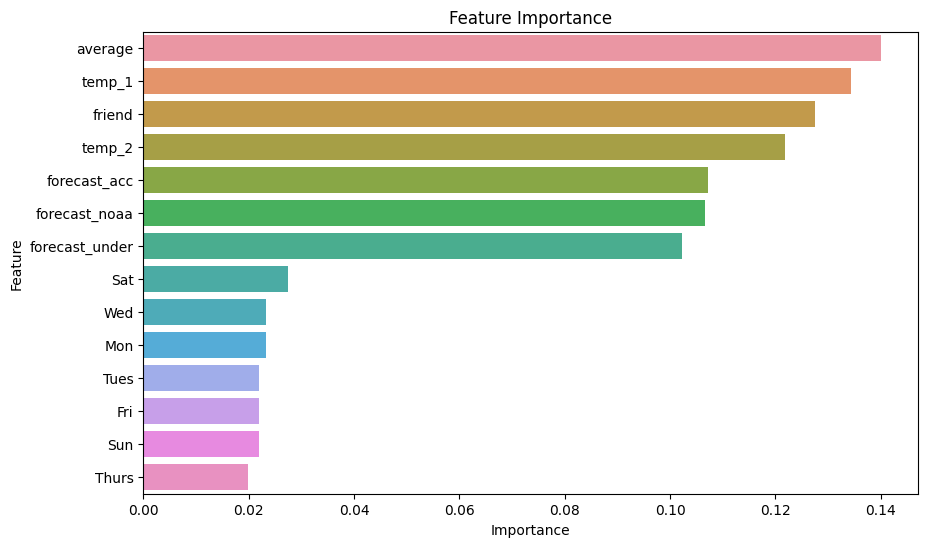

In [150]:
# Get feature importances
importances = rf.feature_importances_
# Get feature_names
columnas=list(temps_df.columns.values)
columnas.remove('actual')
# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame(
    {'Feature': columnas, 'Importance': importances}
)

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the feature importances
sns.barplot(x='Importance', y='Feature', data=feature_importances, ax=ax)

# Set the title and labels
ax.set_title('Feature Importance')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')

Comnetario: Se puede observar que el predictor "Average" es un buen candidato para predecir la temperatura.

#9. 
Obtenga las métricas de precisión.

In [151]:
# true and predicted values
y_true = y_test
y_pred = y_pred

# Mean Squared Error (MSE)
print("Comparativa Bosque Aleatorio v/s Arbol de Desición")
mse = mean_squared_error(y_true, y_pred)
print(f"(MSE) RandomForestClassifier : {mse:.4f} {metric_tree_classifier[0]}")
# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f"(RMSE) RandomForestClassifier: {rmse:.4f} {metric_tree_classifier[1]}")
# Mean Absolute Deviation (MAD)
mad = mean_absolute_error(y_true, y_pred)
print(f"(MAD) RandomForestClassifier : {mad:.4f} {metric_tree_classifier[2]}")

Comparativa Bosque Aleatorio v/s Arbol de Desición
(MSE) RandomForestClassifier : 42.2069 ['DecisionTreeClassifier:51.51724137931034']
(RMSE) RandomForestClassifier: 6.4967 ['DecisionTreeClassifier:7.177551210497236']
(MAD) RandomForestClassifier : 4.4598 ['DecisionTreeClassifier:5.425287356321839']


#10. 
¿Considera que el modelo es adecuado?

El modelo random forest mejora la predicción en comparación con un árbol de decisión aunque considero que se podría realizar algún preprocesamiento para eliminar datos outlier en las variables explicativas como se observó anteriormente y así podría mejorar los resultados.
Sinceramente, creo que no es modelo definitvo para predecir la temperatura real.